In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from string import digits
import datetime
import re
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer
import json
import plotly.express as px
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df_tweets = pd.read_csv(os.path.join('data', 'binance', 'binance_tweets_original.csv'))
df_price = pd.read_csv(os.path.join('data', 'binance', 'binance_coin_price_1_yr.csv'))

In [3]:
df_price

,Date,Close/Last,Volume,Open,High,Low
0,06/02/2022,308.21,NaN,300.50,310.20,306.60
1,06/01/2022,300.02,NaN,319.21,303.81,298.38
2,05/31/2022,319.32,NaN,320.80,324.29,318.52
3,05/30/2022,315.60,NaN,302.72,321.21,304.10
4,05/29/2022,316.81,NaN,300.91,318.11,304.10
...,...,...,...,...,...,...
358,06/07/2021,345.92,NaN,399.23,365.89,332.03
359,06/06/2021,399.19,NaN,398.06,406.99,390.47
360,06/05/2021,392.32,NaN,412.46,399.77,387.18
361,06/04/2021,410.64,NaN,406.32,415.05,388.13


In [5]:
df_tweets.head()

,re_tweeter,links,author,text,hashtags,reply_count,associated_tweet,timestamp,mentions,author_id,retweet_count,type,id,favorite_count
0,NaN,NaN,CZ Binance,"I love most tihings in the world, but I hate j...",NaN,NaN,NaN,1654195218,NaN,NaN,NaN,Tweet,1532431931656261632,NaN
1,NaN,NaN,CZ Binance,#MalaysiaBoleh,NaN,NaN,NaN,1654181362,NaN,NaN,NaN,Tweet,1532373816135008256,NaN
2,NaN,NaN,CZ Binance,Just finished a live interview with CNBC Squaw...,NaN,NaN,NaN,1654167185,NaN,NaN,NaN,Tweet,1532314352384151552,NaN
3,NaN,['https:\\/\\/t.co\\/uh837JZjok'],CZ Binance,I'll be speaking at the Point Zero Forum in Zu...,NaN,NaN,NaN,1654163469,NaN,NaN,NaN,Tweet,1532298767310929920,NaN
4,NaN,NaN,CZ Binance,Humbled to receive this #cryptowarrior gift fr...,NaN,NaN,NaN,1654153218,NaN,NaN,NaN,Tweet,1532255772624580608,NaN


### Data Preprocessing on tweets

In [6]:
df_tweets['datetime'] = pd.to_datetime(df_tweets['timestamp'], unit='s')

In [7]:
df_tweets['date'] = df_tweets['datetime'].apply(lambda x: x.date())
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

In [8]:
df_tweets.columns

Index(['re_tweeter', 'links', 'author', 'text', 'hashtags', 'reply_count',
       'associated_tweet', 'timestamp', 'mentions', 'author_id',
       'retweet_count', 'type', 'id', 'favorite_count', 'datetime', 'date'],
      dtype='object')

In [9]:
df_tweets.drop(columns=['re_tweeter', 'links', 'hashtags', 'associated_tweet', 'mentions', 'author_id', 'reply_count', 'retweet_count', 'type', 'id', 'favorite_count'], inplace=True)

In [10]:
df_tweets.dropna(inplace=True)

In [71]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # remove punctuation
    PUNCT_TO_REMOVE = string.punctuation
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    # lower text
    text = text.lower()
    # remove new lines in the text 
    text = re.sub(r"\n+", " ", text)
    tknzr = TweetTokenizer()
    text = tknzr.tokenize(text)
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)


In [72]:
df_tweets["text_cleaned"] = df_tweets["text"].apply(lambda x: clean_text(x))

In [73]:
df_tweets.describe(include='all')

c:\Users\Jeff\anaconda3\envs\machine-learning\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,author,text,timestamp,datetime,date,text_cleaned,vader_sentiment,flair_classification,flair_classification_cleaned
count,1672,1672,1.672000e+03,1672,1672,1672,1672.000000,1672.000000,1672.000000
unique,1,1628,NaN,1628,382,1602,NaN,NaN,NaN
top,CZ Binance,#Binance,NaN,2022-05-15 08:27:39,2021-05-09 00:00:00,binance,NaN,NaN,NaN
freq,1672,13,NaN,3,18,15,NaN,NaN,NaN
first,NaN,NaN,NaN,2021-04-22 05:29:58,2021-04-22 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2022-06-02 18:40:18,2022-06-02 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,1.636896e+09,NaN,NaN,NaN,0.150127,0.018488,-0.035996
std,NaN,NaN,1.151217e+07,NaN,NaN,NaN,0.363920,0.931748,0.920180
min,NaN,NaN,1.619069e+09,NaN,NaN,NaN,-0.975000,-0.999997,-0.999991
25%,NaN,NaN,1.625884e+09,NaN,NaN,NaN,0.000000,-0.990662,-0.986202


In [74]:
df_tweets.head()

,author,text,timestamp,datetime,date,text_cleaned,vader_sentiment,flair_classification,flair_classification_cleaned
0,CZ Binance,"I love most tihings in the world, but I hate j...",1654195218,2022-06-02 18:40:18,2022-06-02,love tihings world hate jet lag,-0.7717,0.995204,0.990090
1,CZ Binance,#MalaysiaBoleh,1654181362,2022-06-02 14:49:22,2022-06-02,malaysiaboleh,0.0000,0.583073,0.867735
2,CZ Binance,Just finished a live interview with CNBC Squaw...,1654167185,2022-06-02 10:53:05,2022-06-02,finish live interview cnbc squawk box studio haha,0.4588,-0.642573,-0.965842
3,CZ Binance,I'll be speaking at the Point Zero Forum in Zu...,1654163469,2022-06-02 09:51:09,2022-06-02,ill speak point zero forum zurich switzerland ...,0.0000,0.716512,-0.994749
4,CZ Binance,Humbled to receive this #cryptowarrior gift fr...,1654153218,2022-06-02 07:00:18,2022-06-02,humble receive cryptowarrior gift malaysia par...,0.4404,0.997130,0.995697


### Data Preprocess on Price

In [15]:
df_price['date'] = pd.to_datetime(df_price['Date'], format="%m/%d/%Y")

### Exploration

In [64]:
sentence = df_tweets['text_cleaned'][25]
sentence


'blockchain new technology money develop local crypto industry today devastate effect future local economy'

In [25]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence) # compound is the sentiment score

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jeff\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [26]:
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

c:\Users\Jeff\anaconda3\envs\machine-learning\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


2022-06-06 20:30:40,450 loading file C:\Users\Jeff\.flair\models\sentiment-en-mix-distillbert_4.pt


In [65]:
s = flair.data.Sentence(sentence)
flair_sentiment.predict(s)
total_sentiment = s.labels
total_sentiment

['Sentence: "blockchain new technology money develop local crypto industry today devastate effect future local economy"'/'NEGATIVE' (0.9989)]

In [99]:
from textblob import TextBlob
TextBlob(sentence).sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

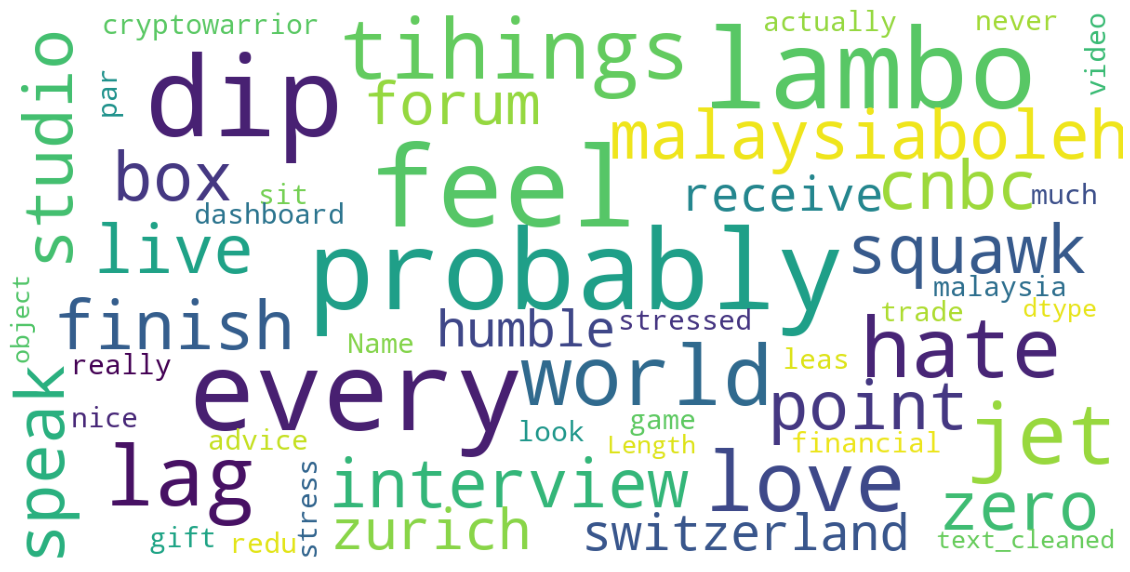

In [100]:
# wordcloud function


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words =800,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df_tweets["text_cleaned"])

### Polarity score by Vader

In [27]:
def add_vader_score(text):
    # No need preprocessing
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)['compound']

df_tweets['vader_sentiment'] = df_tweets['text'].apply(add_vader_score)


In [28]:
fig = px.histogram(df_tweets, x='vader_sentiment', nbins=30)
fig.show()

### Polarity score by Flair

In [29]:
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')

2022-06-06 20:31:53,307 loading file C:\Users\Jeff\.flair\models\sentiment-en-mix-distillbert_4.pt


In [36]:
def add_flair_score(text):
    if len(text) == 0:
        return 0
    sentence = Sentence(text)
    classifier.predict(sentence)
    value = sentence.labels[0].to_dict()['value']
    confidence = sentence.labels[0].to_dict()['confidence']
    if value == 'POSITIVE':
        return 1 * confidence
    else:
        return -1 * confidence

    

In [81]:
df_tweets['flair_sentiment'] = df_tweets['text'].apply(add_flair_score)

In [40]:
fig = px.histogram(df_tweets, x='flair_sentiment')
fig.show()

##### Inspection

In [69]:
print(df_tweets[df_tweets['flair_classification'] > 0.8]['text'].iloc[42])

Meeting the #Binance Angels in Germany yesterday.Binance Angels are community volunteers, not paid. They are mission driven.


In [108]:
df_tweets.loc[1716].text

'Actually, if you feel stressed out during every dip, you should probably reduce your position by 2x. Repeat until you no longer feel stressful.nfa.'

### Polarity score by TextBlob


In [78]:
def add_textBlob_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [82]:
df_tweets['textBlob_sentiment'] = df_tweets['text'].apply(add_textBlob_sentiment)

In [83]:
df_tweets['textBlob_sentiment'].value_counts()

 0.000000    751
 0.500000     58
 0.250000     41
 0.136364     39
 0.200000     34
            ... 
 0.044444      1
 0.118182      1
-0.141667      1
 0.393074      1
 0.339394      1
Name: textBlob_sentiment, Length: 380, dtype: int64

In [84]:
fig = px.histogram(df_tweets, x='textBlob_sentiment', nbins=30)
fig.show()

### Price Correlation with Sentiment

In [85]:
df_tweets.head()

,author,text,timestamp,datetime,date,text_cleaned,vader_sentiment,flair_sentiment,textBlob_sentiment
0,CZ Binance,"I love most tihings in the world, but I hate j...",1654195218,2022-06-02 18:40:18,2022-06-02,love tihings world hate jet lag,-0.7717,0.995204,0.066667
1,CZ Binance,#MalaysiaBoleh,1654181362,2022-06-02 14:49:22,2022-06-02,malaysiaboleh,0.0000,0.583073,0.000000
2,CZ Binance,Just finished a live interview with CNBC Squaw...,1654167185,2022-06-02 10:53:05,2022-06-02,finish live interview cnbc squawk box studio haha,0.4588,-0.642573,0.168182
3,CZ Binance,I'll be speaking at the Point Zero Forum in Zu...,1654163469,2022-06-02 09:51:09,2022-06-02,ill speak point zero forum zurich switzerland ...,0.0000,0.716512,0.000000
4,CZ Binance,Humbled to receive this #cryptowarrior gift fr...,1654153218,2022-06-02 07:00:18,2022-06-02,humble receive cryptowarrior gift malaysia par...,0.4404,0.997130,0.000000


In [87]:
df_price.head()

,Date,Close/Last,Volume,Open,High,Low,date
0,06/02/2022,308.21,NaN,300.50,310.20,306.60,2022-06-02
1,06/01/2022,300.02,NaN,319.21,303.81,298.38,2022-06-01
2,05/31/2022,319.32,NaN,320.80,324.29,318.52,2022-05-31
3,05/30/2022,315.60,NaN,302.72,321.21,304.10,2022-05-30
4,05/29/2022,316.81,NaN,300.91,318.11,304.10,2022-05-29


In [88]:
df_tweets['date'] = pd.to_datetime(df_tweets['date'])

In [90]:
df_combined = pd.merge(df_tweets, df_price, on="date")
# df_combined = df_tweets.merge(df_price, on='date', how='outer')

In [91]:
df_combined.head()

,author,text,timestamp,datetime,date,text_cleaned,vader_sentiment,flair_sentiment,textBlob_sentiment,Date,Close/Last,Volume,Open,High,Low
0,CZ Binance,"I love most tihings in the world, but I hate j...",1654195218,2022-06-02 18:40:18,2022-06-02,love tihings world hate jet lag,-0.7717,0.995204,0.066667,06/02/2022,308.21,NaN,300.5,310.2,306.6
1,CZ Binance,#MalaysiaBoleh,1654181362,2022-06-02 14:49:22,2022-06-02,malaysiaboleh,0.0000,0.583073,0.000000,06/02/2022,308.21,NaN,300.5,310.2,306.6
2,CZ Binance,Just finished a live interview with CNBC Squaw...,1654167185,2022-06-02 10:53:05,2022-06-02,finish live interview cnbc squawk box studio haha,0.4588,-0.642573,0.168182,06/02/2022,308.21,NaN,300.5,310.2,306.6
3,CZ Binance,I'll be speaking at the Point Zero Forum in Zu...,1654163469,2022-06-02 09:51:09,2022-06-02,ill speak point zero forum zurich switzerland ...,0.0000,0.716512,0.000000,06/02/2022,308.21,NaN,300.5,310.2,306.6
4,CZ Binance,Humbled to receive this #cryptowarrior gift fr...,1654153218,2022-06-02 07:00:18,2022-06-02,humble receive cryptowarrior gift malaysia par...,0.4404,0.997130,0.000000,06/02/2022,308.21,NaN,300.5,310.2,306.6


### Group the data by Week

In [94]:
df_resampled = df_combined.resample('W', on='date').mean().dropna(how='all')

In [95]:
df_resampled.head()

,timestamp,vader_sentiment,flair_sentiment,textBlob_sentiment,Close/Last,Volume,Open,High,Low
date,,,,,,,,,
2021-06-06,1.622862e+09,0.161474,-0.029036,0.130702,401.680526,NaN,404.743158,409.541579,389.154211
2021-06-13,1.623317e+09,0.106596,-0.518206,0.037776,349.472692,NaN,358.276538,362.160385,343.480000
2021-06-20,1.623931e+09,0.285282,0.059619,0.089781,345.945152,NaN,352.927879,349.909091,341.653030
2021-06-27,1.624520e+09,-0.049767,-0.219633,0.035144,287.689394,NaN,298.202121,293.185152,277.330000
2021-07-04,1.625150e+09,0.249543,-0.010062,0.081328,290.061739,NaN,290.590435,298.854348,287.977826


### Visualization

In [97]:
# Multiply the column to make the magnitude comparable
df_plot = df_resampled.copy()
df_plot['vader_sentiment_1000'] = df_plot['vader_sentiment'].apply(lambda x: x * 1000)
df_plot['flair_sentiment_1000'] = df_plot['flair_sentiment'].apply(lambda x: x * 1000)
df_plot['textBlob_sentiment_1000'] = df_plot['textBlob_sentiment'].apply(lambda x: x * 1000)

In [99]:
fig = px.line(df_plot, y=['vader_sentiment_1000', 'flair_sentiment_1000', 'textBlob_sentiment_1000', 'Close/Last'])
fig.show()

In [100]:
fig = px.line(df_plot, y=['Close/Last'])
fig.show()


#### Correlation - Numerical Analysis

In [101]:
df_resampled_1 = df_resampled.drop(columns=['timestamp', 'Volume', 'Open', 'High', 'Low'])
df_resampled_corr = df_resampled_1.corr()

In [102]:
df_resampled_corr

,vader_sentiment,flair_sentiment,textBlob_sentiment,Close/Last
vader_sentiment,1.000000,0.254265,0.380334,-0.066857
flair_sentiment,0.254265,1.000000,0.144934,0.082361
textBlob_sentiment,0.380334,0.144934,1.000000,0.015206
Close/Last,-0.066857,0.082361,0.015206,1.000000


In [103]:
px.imshow(df_resampled_corr)

### Analysis on Price Change
Sentiment may not directly indicate a high or low price in the market, but an possible underlying movement in the market. So I proceed to check 
- whether price change is correlated to the polarity of the sentiment score
- whether the text sentiment could be used to predict the price movement

The second question turns this into a supervised machine learning problem. Logistic Regression, SVM, Decision Tree, Random Forest and even Deep Learning could be applied to classify if the text would belong to the 'upward' class or 'downward' class. 

In [105]:
df_resampled['price_change'] = df_resampled['Close/Last'] - df_resampled['Open']
df_resampled['movement'] = df_resampled['price_change'].apply(lambda x: 1 if x >= 0 else 0)

In [106]:
# Delta
df_resampled.head()

,timestamp,vader_sentiment,flair_sentiment,textBlob_sentiment,Close/Last,Volume,Open,High,Low,price_change,movement
date,,,,,,,,,,,
2021-06-06,1.622862e+09,0.161474,-0.029036,0.130702,401.680526,NaN,404.743158,409.541579,389.154211,-3.062632,0
2021-06-13,1.623317e+09,0.106596,-0.518206,0.037776,349.472692,NaN,358.276538,362.160385,343.480000,-8.803846,0
2021-06-20,1.623931e+09,0.285282,0.059619,0.089781,345.945152,NaN,352.927879,349.909091,341.653030,-6.982727,0
2021-06-27,1.624520e+09,-0.049767,-0.219633,0.035144,287.689394,NaN,298.202121,293.185152,277.330000,-10.512727,0
2021-07-04,1.625150e+09,0.249543,-0.010062,0.081328,290.061739,NaN,290.590435,298.854348,287.977826,-0.528696,0


#### Visualization

In [107]:
df_resampled_2 = df_resampled.drop(columns=['timestamp', 'Volume', 'Open', 'High', 'Low'])

In [109]:
fig = px.line(df_resampled, y=['vader_sentiment', 'flair_sentiment', 'textBlob_sentiment', 'movement'])
fig.show()


In [157]:
px.imshow(df_resampled_2.corr(), color_continuous_scale='ice')

### Findings
- Among the three classifier, Flair's sentiment score (continous variable) is the mostly correlated to the price movement (binary variable). 
- Flair's sentiment score (continous variable) is also mostly correlated to the price change (continous variable).
- A considerable amount of noise is presented in the sentiment rating as some of the negative meanings is expressed towards traditional finance which should be bullish to the crypto market. This may require further labeling to training a good model. 
- TextBlob and Vader shows similar trend due their simple schema is ranking the positive and negative words. Flair reasonably gives different socres compared to the other two since it is trained with a LSTM model. 
- Classification on the text by price movement will be done in another file.

### Suggestions
- A critical point for sentiment analysis would be there are a lot of neutral tweets but we do not have this label since it is impossible for close and open price to be the same, not to mention this would not necessarily imply neutral sentiment. 

- Use tweets from a wider range of accounts so as to populate a larger dataset
- Use mannual labeling of positive/negative sentiment instead of relying on the price movement.
- May use other correlation metrics but not only the Pearson's
- Use different metrics to weight the sentiment score of different tweets of the same day

